# Designing and creating a database

In this guided project, we're going to learn how to:

- Import data into SQLite
- Design a normalized database schema
- Create tables for our schema
- Insert data into our schema

We will be working with a file of Major League Baseball games from Retrosheet. Retrosheet compiles detailed statistics on baseball games from the 1800s through to today. The main file we will be working from game_log.csv, has been produced by combining 127 separate CSV files from retrosheet. The game log has hundreds of data points on each game which we will normalize into several separate tables using SQL, providing a robust database of game-level statistics.

In addition to the main file, we have also included three 'helper' files, also sourced from Retrosheet:

- park_codes.csv
- person_codes.csv
- team_codes.csv

### Perform exploratory data analysis (EDA)

In [1]:
import pandas as pd
import sqlite3
pd.set_option('max_columns', 180)
pd.set_option('max_rows', 200000)
pd.set_option('max_colwidth', 5000)

files= ['game_log.csv', 'park_codes.csv', 'person_codes.csv', 'team_codes.csv', 'appearance_type.csv']

def eda(filename):
    df = pd.read_csv(filename,low_memory=False)
    print("----------")
    print(filename)
    print(df.shape)
#     print(df.dtypes)
    print("----------")

for file in files:
    eda(file)

----------
game_log.csv
(171907, 161)
----------
----------
park_codes.csv
(252, 9)
----------
----------
person_codes.csv
(20494, 7)
----------
----------
team_codes.csv
(150, 8)
----------
----------
appearance_type.csv
(31, 3)
----------


### Define SQL functions for sqlite3 connectivity

In [2]:
def run_query(q):
    '''Takes an SQL query and runs a pandas dataframe of it'''
    with sqlite3.connect('mlb.db') as conn:
        return pd.read_sql(q, conn)

def show_tables():
    q="SELECT name, type FROM sqlite_master WHERE type IN ('table', 'view');"
    return run_query(q)

def drop_view(view_name):
    c="DROP VIEW "+view_name+";"
    run_command(c)
    
    
def run_command(c):
    '''Takes an SQL command as an argument and executes it'''
    with sqlite3.connect("mlb.db") as conn:
        #enable foreign keys
        conn.execute('PRAGMA foreign_keys = ON;')
        #autocommit any changes:
        conn.isolation_level = None
        conn.execute(c)

### Proposed database schema:

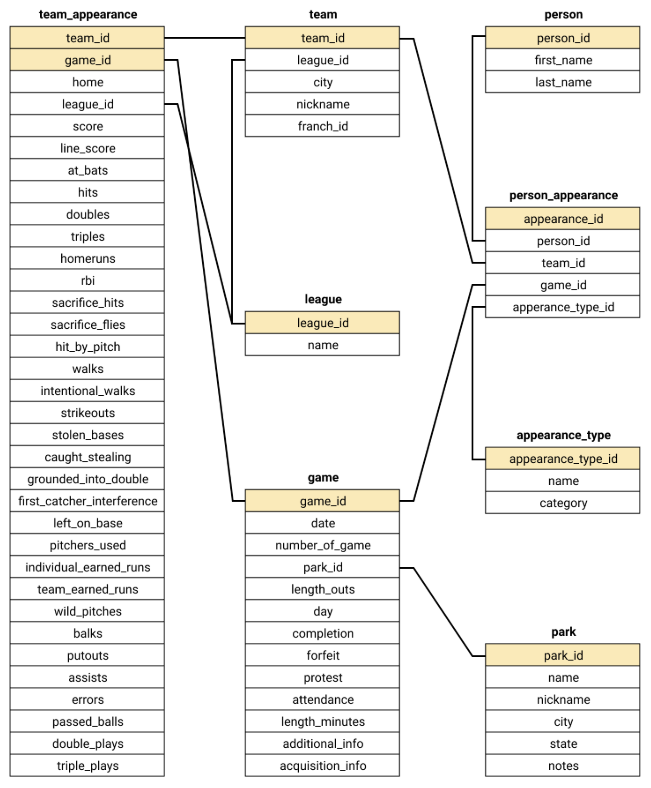

The following schema was planned using DbDesigner.net:

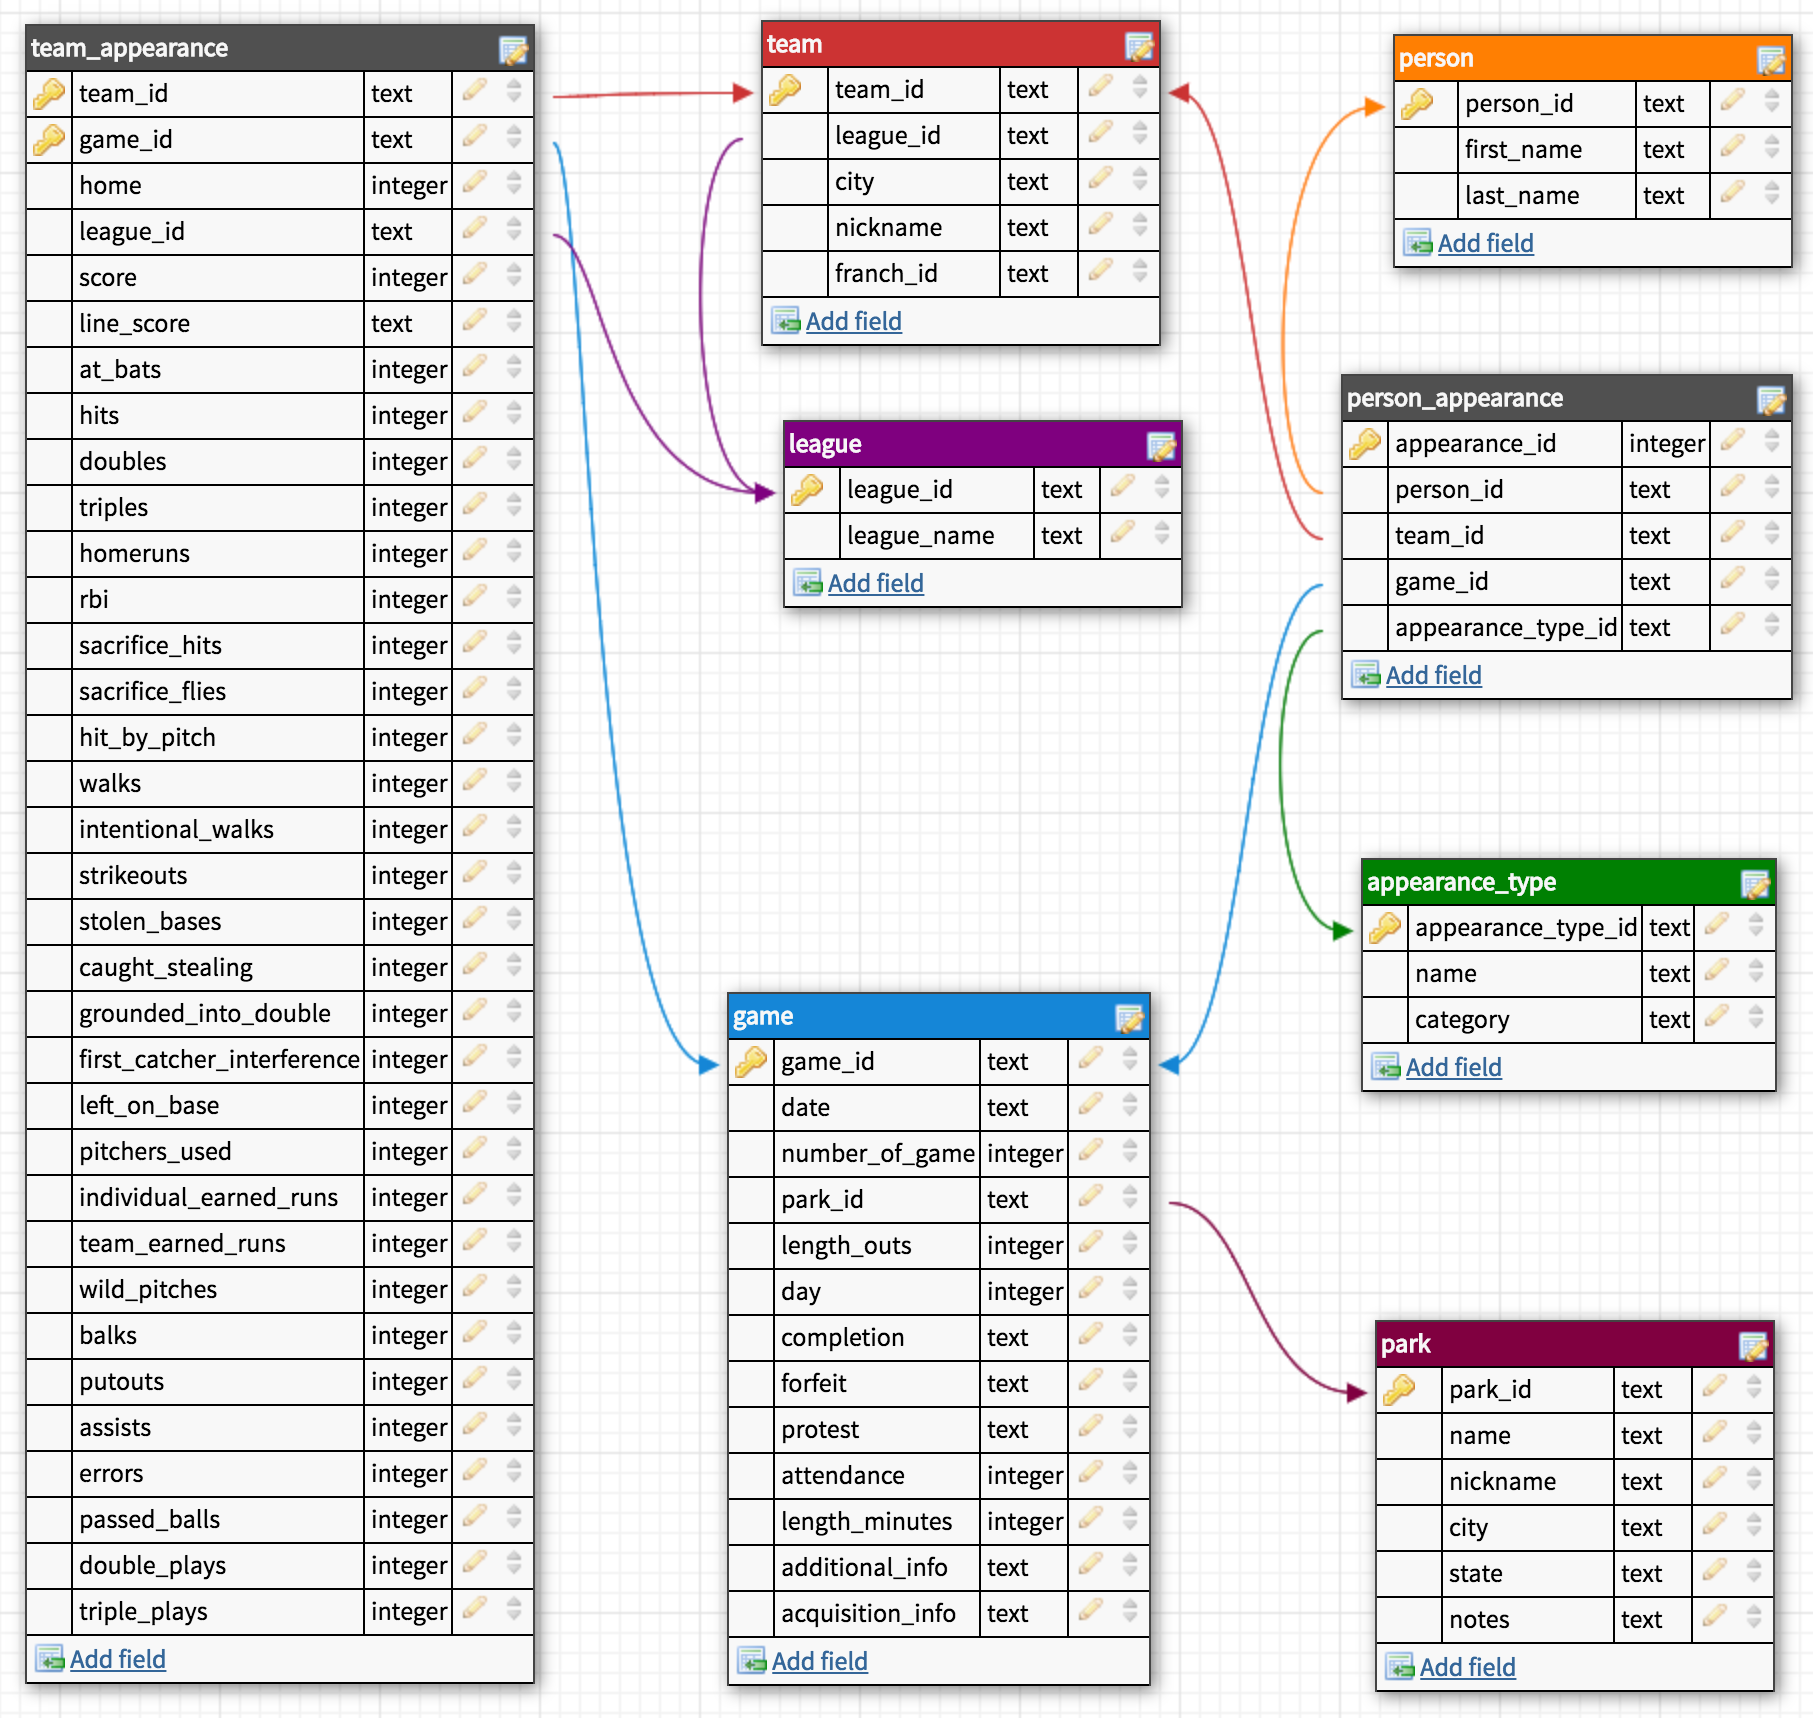

### Create the database
### Then populate the game_log table from which the schema tables will be created

In [42]:
#add a table to the database:
DB = "mlb.db"
game_log_df = pd.read_csv('game_log.csv',low_memory=False)
game_log_df.to_sql('game_log',sqlite3.connect(DB), index=False)

In [4]:
%load_ext sql
%sql sqlite:///mlb.db

'Connected: @mlb.db'

In [5]:
show_tables()

,name,type
0,game_log,table


### Add game_id column to the game_log table and populate with IDs

In [43]:
c="ALTER TABLE game_log ADD COLUMN game_id TEXT"
run_command(c)

c="UPDATE game_log SET game_id = h_name||date||number_of_game"
run_command(c)

q= "SELECT game_id FROM game_log LIMIT 3;"
run_query(q)

,game_id
0,FW1187105040
1,WS3187105050
2,RC1187105060


### Then create tables that do not contain foreign key relations: 

- person, 
- park, 
- league, 
- appearance_type

It's important to start with these tables, as other tables will have relations to these tables, and so these tables will need to exist first.

1. Create each table
2. Inset the data

In [7]:
#read data into the database
DB = "mlb.db"
pd.read_csv('park_codes.csv',low_memory=False).to_sql('park_codes',sqlite3.connect(DB), index=False)
pd.read_csv('person_codes.csv',low_memory=False).to_sql('person_codes',sqlite3.connect(DB), index=False)
pd.read_csv('team_codes.csv',low_memory=False).to_sql('team_codes',sqlite3.connect(DB), index=False)
pd.read_csv('appearance_type.csv',low_memory=False).to_sql('appearance_type_table',sqlite3.connect(DB), index=False)

show_tables()

,name,type
0,game_log,table
1,park_codes,table
2,person_codes,table
3,team_codes,table
4,appearance_type_table,table


### Create and populate the person table

In [8]:
c= "CREATE TABLE person (person_id TEXT PRIMARY KEY, first_name TEXT, last_name TEXT)"
run_command(c)

c="INSERT INTO person SELECT id, first, last FROM person_codes;"
run_command(c)

q="SELECT * FROM person LIMIT 3"
run_query(q)

,person_id,first_name,last_name
0,aardd001,David,Aardsma
1,aaroh101,Hank,Aaron
2,aarot101,Tommie,Aaron


### Create and populate the park table

In [9]:
c= "CREATE TABLE park (park_id TEXT PRIMARY KEY, name TEXT, nickname TEXT, city TEXT, state TEXT, notes TEXT)"
run_command(c)
c="INSERT INTO park SELECT park_id , name, aka, city, state, notes FROM park_codes"
run_command(c)

q="SELECT * FROM park LIMIT 3"
run_query(q)

,park_id,name,nickname,city,state,notes
0,ALB01,Riverside Park,None,Albany,NY,TRN:9/11/80;6/15&9/10/1881;5/16-5/18&5/30/1882
1,ALT01,Columbia Park,None,Altoona,PA,None
2,ANA01,Angel Stadium of Anaheim,Edison Field; Anaheim Stadium,Anaheim,CA,None


### Create and populate the league table

In [10]:
c= "CREATE TABLE league (league_id TEXT PRIMARY KEY, name TEXT)"
run_command(c)

q="SELECT Distinct(league) FROM team_codes"
run_query(q)

,league
0,UA
1,NL
2,PL
3,None
4,AA
5,AL
6,FL


From web research the acronyms in the database stand for:

- The Union Association 
- The National League of Professional Baseball Clubs
- The Players' National League of Professional Base Ball Clubs
- Double-A
- The American League of Professional Baseball Clubs
- The Federal League of Base Ball Clubs

In [11]:
%%sql
INSERT INTO league 

(league_id, name) 
VALUES 

("UA","The Union Association"), 
("NL","The National League of Professional Baseball Clubs"), 
("PL","The Players\' National League of Professional Base Ball Clubs"),
("AA","Double-A"), ("AL","The American League of Professional Baseball Clubs"), 
("FL","The Federal League of Base Ball Clubs");

 * sqlite:///mlb.db
6 rows affected.


[]

In [12]:
c="SELECT * FROM league"
run_query(c)

,league_id,name
0,UA,The Union Association
1,NL,The National League of Professional Baseball Clubs
2,PL,The Players\' National League of Professional Base Ball Clubs
3,AA,Double-A
4,AL,The American League of Professional Baseball Clubs
5,FL,The Federal League of Base Ball Clubs


### Create and populate appearance_type table

In [13]:
c= "CREATE TABLE appearance_type (appearance_type_id TEXT PRIMARY KEY, name TEXT, category TEXT)"
run_command(c)
c="INSERT INTO appearance_type SELECT appearance_type_id, name, category FROM appearance_type_table"
run_command(c)

q="SELECT * from appearance_type LIMIT 3"
run_query(q)

,appearance_type_id,name,category
0,O1,Batter 1,offense
1,O2,Batter 2,offense
2,O3,Batter 3,offense


In [14]:
show_tables()

,name,type
0,game_log,table
1,park_codes,table
2,person_codes,table
3,team_codes,table
4,appearance_type_table,table
5,person,table
6,park,table
7,league,table
8,appearance_type,table


### Below I highlighted the tables that are already completed:

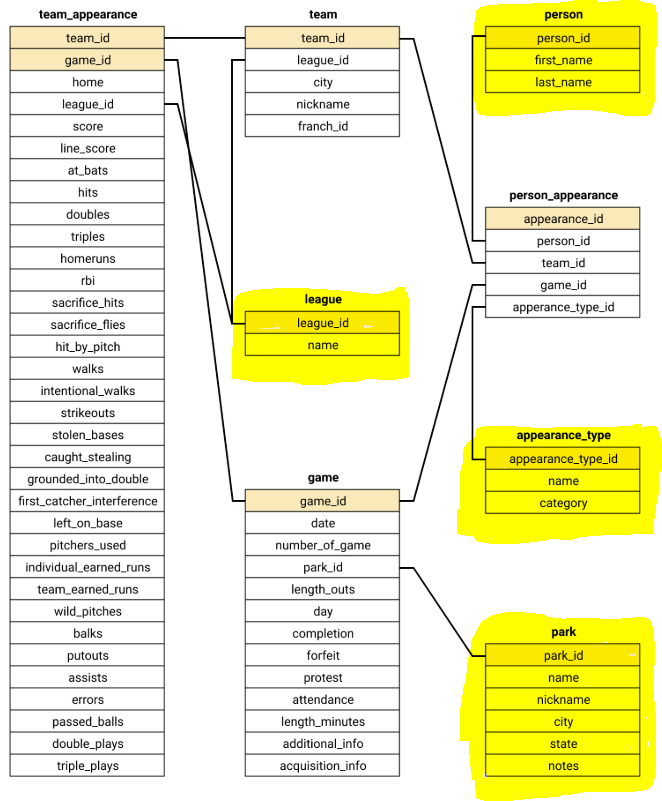

### Next create and populate team and game tables

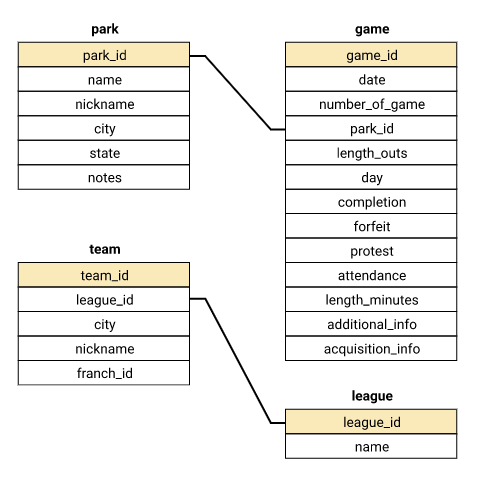

### Team table:

In [15]:
%%sql
CREATE TABLE team
(
    team_id TEXT PRIMARY KEY, 
    league_id TEXT, 
    city TEXT, 
    nickname TEXT, 
    franch_id TEXT, 
    
    FOREIGN KEY (league_id) REFERENCES league(league_id)
);

 * sqlite:///mlb.db
Done.


[]

In [16]:
#insert data from team_codes table 
c="INSERT INTO team SELECT team_id, league, city, nickname, franch_id FROM team_codes GROUP BY team_id"
run_command(c)

### group by was used to reduce duplicate team id present in the data

In [17]:
q="SELECT * FROM team LIMIT 5"
run_query(q)

,team_id,league_id,city,nickname,franch_id
0,ALT,UA,Altoona,Mountain Cities,ALT
1,ANA,AL,Anaheim,Angels,LAA
2,ARI,NL,Arizona,Diamondbacks,ARI
3,ATL,NL,Atlanta,Braves,BS1
4,BAL,AL,Baltimore,Orioles,MLA


### Game table:

In [18]:
%%sql

CREATE TABLE game
(
    game_id TEXT PRIMARY KEY, 
    date INTEGER, 
    number_of_game INTEGER, 
    park_id TEXT, 
    length_outs REAL, 
    day TEXT, 
    completion TEXT, 
    forfeit TEXT, 
    protest TEXT, 
    attendance REAL, 
    length_minutes REAL, 
    additional_info TEXT, 
    acquisition_info TEXT, 
    
    FOREIGN KEY (park_id) REFERENCES park(park_id)
);

 * sqlite:///mlb.db
Done.


[]

In [19]:
%%sql

INSERT INTO game 
SELECT 
game_id, 
date, 
number_of_game, 
park_id, 
length_outs, 
day_of_week, 
completion, 
forefeit, 
protest, 
attendance, 
length_minutes, 
additional_info, 
acquisition_info 

FROM game_log;

 * sqlite:///mlb.db
171907 rows affected.


[]

In [20]:
q="SELECT * FROM game LIMIT 4"
run_query(q)

,game_id,date,number_of_game,park_id,length_outs,day,completion,forfeit,protest,attendance,length_minutes,additional_info,acquisition_info
0,FW1187105040,18710504,0,FOR01,54.0,Thu,None,None,None,200.0,120.0,None,Y
1,WS3187105050,18710505,0,WAS01,54.0,Fri,None,None,None,5000.0,145.0,HTBF,Y
2,RC1187105060,18710506,0,RCK01,54.0,Sat,None,None,None,1000.0,140.0,None,Y
3,CH1187105080,18710508,0,CHI01,54.0,Mon,None,None,None,5000.0,150.0,None,Y


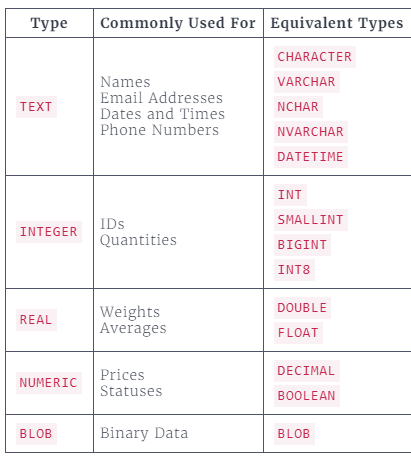

In [21]:
# Example showing that it is not easy to delete a table with a foreign constraint
c='DELETE FROM park where park_id = "FOR01";'
run_command(c)

IntegrityError: FOREIGN KEY constraint failed

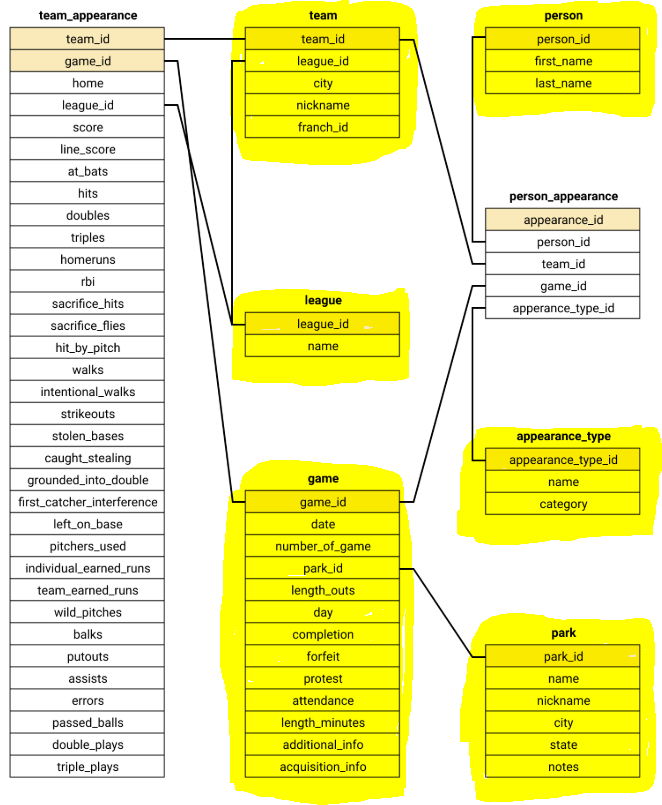

### Create and populate team_appearance table

In [22]:
%%sql
CREATE TABLE team_appearance
(
    team_id TEXT,
    game_id TEXT,
    home NUMERIC,
    league_id TEXT,
    score INTEGER,
    line_score INTEGER,
    at_bats INTEGER,
    hits INTEGER,
    doubles INTEGER,
    triples INTEGER,
    homeruns INTEGER,
    rbi INTEGER,
    sacrifice_hits INTEGER,
    sacrifice_flies INTEGER,
    hit_by_pitch INTEGER,
    walks INTEGER,
    intentional_walks INTEGER,
    strikeouts INTEGER,
    stolen_bases INTEGER,
    caught_stealing INTEGER,
    grounded_into_double INTEGER,
    first_catcher_interface INTEGER,
    left_on_base INTEGER,
    pitchers_used INTEGER,
    individual_earned_runs INTEGER,
    team_earned_runs INTEGER,
    wild_pitches INTEGER,
    balks INTEGER,
    putouts INTEGER,
    assists INTEGER,
    errors INTEGER,
    passed_balls INTEGER,
    double_plays INTEGER,
    triple_plays INTEGER,
    PRIMARY KEY(team_id, game_id),
    
    FOREIGN KEY (league_id) REFERENCES league(league_id)
);

 * sqlite:///mlb.db
Done.


[]

In [23]:
%%sql

INSERT INTO team_appearance
    SELECT
        h_name,
        game_id,
        1 AS home,
        h_league,
        h_score,
        h_line_score,
        h_at_bats,
        h_hits,
        h_doubles,
        h_triples,
        h_homeruns,
        h_rbi,
        h_sacrifice_hits,
        h_sacrifice_flies,
        h_hit_by_pitch,
        h_walks,
        h_intentional_walks,
        h_strikeouts,
        h_stolen_bases,
        h_caught_stealing,
        h_grounded_into_double,
        h_first_catcher_interference,
        h_left_on_base,
        h_pitchers_used,
        h_individual_earned_runs,
        h_team_earned_runs,
        h_wild_pitches,
        h_balks,
        h_putouts,
        h_assists,
        h_errors,
        h_passed_balls,
        h_double_plays,
        h_triple_plays
    FROM game_log

    UNION
    SELECT

        v_name,
        game_id,
        0 AS home,
        v_league,
        v_score,
        v_line_score,
        v_at_bats,
        v_hits,
        v_doubles,
        v_triples,
        v_homeruns,
        v_rbi,
        v_sacrifice_hits,
        v_sacrifice_flies,
        v_hit_by_pitch,
        v_walks,
        v_intentional_walks,
        v_strikeouts,
        v_stolen_bases,
        v_caught_stealing,
        v_grounded_into_double,
        v_first_catcher_interference,
        v_left_on_base,
        v_pitchers_used,
        v_individual_earned_runs,
        v_team_earned_runs,
        v_wild_pitches,
        v_balks,
        v_putouts,
        v_assists,
        v_errors,
        v_passed_balls,
        v_double_plays,
        v_triple_plays
    FROM game_log;

 * sqlite:///mlb.db
343814 rows affected.


[]

In [28]:
%%sql
SELECT * FROM team_appearance LIMIT 5 OFFSET 100;

 * sqlite:///mlb.db
Done.


team_id,game_id,home,league_id,score,line_score,at_bats,hits,doubles,triples,homeruns,rbi,sacrifice_hits,sacrifice_flies,hit_by_pitch,walks,intentional_walks,strikeouts,stolen_bases,caught_stealing,grounded_into_double,first_catcher_interface,left_on_base,pitchers_used,individual_earned_runs,team_earned_runs,wild_pitches,balks,putouts,assists,errors,passed_balls,double_plays,triple_plays
ANA,ANA200009110,1,AL,1,100000,33,8,1,0,0,1,0,0,0,2,0,7,0,0,1,0,7,5,2,2,0,1,27,9,2,0,1,0
ANA,ANA200009120,1,AL,5,00001031x,31,8,0,1,0,5,1,0,0,5,0,7,0,0,0,0,8,3,2,2,0,0,27,15,0,0,1,0
ANA,ANA200009130,1,AL,8,00005300x,34,10,2,0,1,7,0,0,0,4,1,6,2,0,1,0,6,3,3,3,0,0,27,11,3,0,1,0
ANA,ANA200009290,1,AL,9,40301100x,33,10,2,1,3,9,0,1,0,5,0,1,1,0,0,0,6,2,1,1,1,0,27,10,2,0,2,0
ANA,ANA200009300,1,AL,9,2004012,39,12,3,0,2,9,0,0,0,3,0,3,0,1,1,0,6,6,21,21,2,0,27,7,1,0,1,0


### Create and populate person_appearance table

In [29]:
files= ['game_log.csv']

def eda(filename):
    df = pd.read_csv(filename,low_memory=False)
    print("----------")
    print(df.dtypes)
    print("----------")

for file in files:
    eda(file)

----------
date                              int64
number_of_game                    int64
day_of_week                      object
v_name                           object
v_league                         object
v_game_number                     int64
h_name                           object
h_league                         object
h_game_number                     int64
v_score                           int64
h_score                           int64
length_outs                     float64
day_night                        object
completion                       object
forefeit                         object
protest                          object
park_id                          object
attendance                      float64
length_minutes                  float64
v_line_score                     object
h_line_score                     object
v_at_bats                       float64
v_hits                          float64
v_doubles                       float64
v_triples                    

### Umpires

hp_umpire_id                     object
1b_umpire_id                     object
2b_umpire_id                     object
3b_umpire_id                     object
lf_umpire_id                     object
rf_umpire_id                     object

### Managers:
v_manager_id                     object
h_manager_id                     object

### Awards
winning_pitcher_id               object
losing_pitcher_id                object
saving_pitcher_id                object
winning_rbi_batter_id            object


### Players
v_player_1_id                    object
v_player_2_id                    object
v_player_3_id                    object
v_player_4_id                    object
v_player_5_id                    object
v_player_6_id                    object
v_player_7_id                    object
v_player_8_id                    object
v_player_9_id                    object

h_player_1_id                    object
h_player_2_id                    object
h_player_3_id                    object
h_player_4_id                    object
h_player_5_id                    object
h_player_6_id                    object
h_player_7_id                    object
h_player_8_id                    object
h_player_9_id                    object

In [40]:
%%sql
CREATE TABLE person_appearance
(
    appearance_id INTEGER PRIMARY KEY,
    person_id TEXT,
    team_id TEXT,
    game_id TEXT,
    appearance_type_id,

    
    FOREIGN KEY (person_id) REFERENCES person(person_id),
    FOREIGN KEY (team_id) REFERENCES team(team_id),
    FOREIGN KEY (game_id) REFERENCES game(game_id),
    FOREIGN KEY (appearance_type_id) REFERENCES appearance_type(appearance_type_id)  
    
    
);

 * sqlite:///mlb.db
Done.


[]

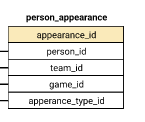

In [44]:
%%sql

INSERT OR IGNORE INTO person_appearance (
    game_id,
    team_id,
    person_id,
    appearance_type_id
) 
    SELECT
        game_id,
        NULL,
        hp_umpire_id,
        "UHP"
    FROM game_log
    WHERE hp_umpire_id IS NOT NULL    

UNION

    SELECT
        game_id,
        NULL,
        [1b_umpire_id],
        "U1B"
    FROM game_log
    WHERE "1b_umpire_id" IS NOT NULL

UNION

    SELECT
        game_id,
        NULL,
        [2b_umpire_id],
        "U2B"
    FROM game_log
    WHERE [2b_umpire_id] IS NOT NULL

UNION

    SELECT
        game_id,
        NULL,
        [3b_umpire_id],
        "U3B"
    FROM game_log
    WHERE [3b_umpire_id] IS NOT NULL

UNION

    SELECT
        game_id,
        NULL,
        lf_umpire_id,
        "ULF"
    FROM game_log
    WHERE lf_umpire_id IS NOT NULL

UNION

    SELECT
        game_id,
        NULL,
        rf_umpire_id,
        "URF"
    FROM game_log
    WHERE rf_umpire_id IS NOT NULL

UNION

    SELECT
        game_id,
        v_name,
        v_manager_id,
        "MM"
    FROM game_log
    WHERE v_manager_id IS NOT NULL

UNION

    SELECT
        game_id,
        h_name,
        h_manager_id,
        "MM"
    FROM game_log
    WHERE h_manager_id IS NOT NULL

UNION

    SELECT
        game_id,
        CASE
            WHEN h_score > v_score THEN h_name
            ELSE v_name
            END,
        winning_pitcher_id,
        "AWP"
    FROM game_log
    WHERE winning_pitcher_id IS NOT NULL

UNION

    SELECT
        game_id,
        CASE
            WHEN h_score < v_score THEN h_name
            ELSE v_name
            END,
        losing_pitcher_id,
        "ALP"
    FROM game_log
    WHERE losing_pitcher_id IS NOT NULL

UNION

    SELECT
        game_id,
        CASE
            WHEN h_score > v_score THEN h_name
            ELSE v_name
            END,
        saving_pitcher_id,
        "ASP"
    FROM game_log
    WHERE saving_pitcher_id IS NOT NULL

UNION

    SELECT
        game_id,
        CASE
            WHEN h_score > v_score THEN h_name
            ELSE v_name
            END,
        winning_rbi_batter_id,
        "AWB"
    FROM game_log
    WHERE winning_rbi_batter_id IS NOT NULL

UNION

    SELECT
        game_id,
        v_name,
        v_starting_pitcher_id,
        "PSP"
    FROM game_log
    WHERE v_starting_pitcher_id IS NOT NULL

UNION

    SELECT
        game_id,
        h_name,
        h_starting_pitcher_id,
        "PSP"
    FROM game_log
    WHERE h_starting_pitcher_id IS NOT NULL;

 * sqlite:///mlb.db
1646118 rows affected.


[]

In [45]:
template = """
INSERT INTO person_appearance (
    game_id,
    team_id,
    person_id,
    appearance_type_id
) 
    SELECT
        game_id,
        {hv}_name,
        {hv}_player_{num}_id,
        "O{num}"
    FROM game_log
    WHERE {hv}_player_{num}_id IS NOT NULL

UNION

    SELECT
        game_id,
        {hv}_name,
        {hv}_player_{num}_id,
        "D" || CAST({hv}_player_{num}_def_pos AS INT)
    FROM game_log
    WHERE {hv}_player_{num}_id IS NOT NULL;
"""

for hv in ["h","v"]:
    for num in range(1,10):
        query_vars = {
            "hv": hv,
            "num": num
        }
        run_command(template.format(**query_vars))

In [46]:
%%sql
SELECT * FROM person_appearance LIMIT 4

 * sqlite:///mlb.db
Done.


appearance_id,person_id,team_id,game_id,appearance_type_id
1,maplb901,None,ALT188404300,UHP
2,curte801,ALT,ALT188404300,MM
3,murpj104,ALT,ALT188404300,PSP
4,hodnc101,SLU,ALT188404300,PSP


### Remove original tables

In [47]:
tables = [
    "game_log",
    "park_codes",
    "team_codes",
    "person_codes"
]

for t in tables:
    c = '''
    DROP TABLE {}
    '''.format(t)
    
    run_command(c)

show_tables()

,name,type
0,appearance_type_table,table
1,person,table
2,park,table
3,league,table
4,appearance_type,table
5,team,table
6,game,table
7,team_appearance,table
8,person_appearance,table
